In [1]:
import csv
import json
import os.path

import librosa
import numpy as np
import pandas as pd
from bidict import bidict
from matplotlib import pyplot as plt
import python_speech_features
from scipy.io import wavfile



from scipy.signal import spectrogram

from utils.instrument_data import DataPreprocessor

#### Load Config

In [2]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["IRMAS_NOVOICE_Training_Path_Alt"]

CLASS_DICTIONARY = bidict({
    0 : "cel",
    1 : "cla",
    2 : "flu",
    3 : "gac",
    4 : "gel",
    5 : "org",
    6 : "pia",
    7 : "sax",
    8 : "tru",
    9 : "vio"
})

#### Create Dataframe and Check Class Distribution

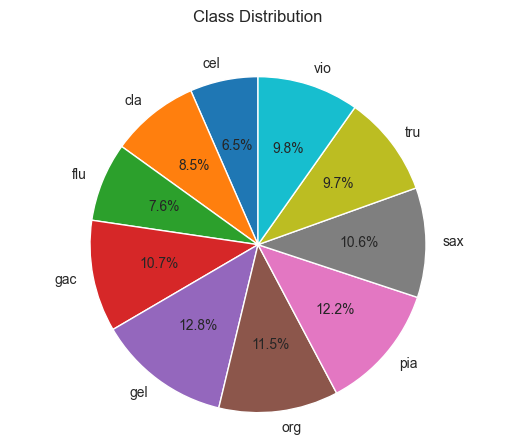

Index(['cel\008__[cel][nod][cla]0058__1.wav',
       'cel\008__[cel][nod][cla]0058__2.wav',
       'cel\008__[cel][nod][cla]0058__3.wav',
       'cel\012__[cel][nod][cla]0043__1.wav',
       'cel\012__[cel][nod][cla]0043__2.wav',
       'cel\012__[cel][nod][cla]0043__3.wav',
       'cel\013__[cel][nod][cla]0025__1.wav',
       'cel\013__[cel][nod][cla]0025__2.wav',
       'cel\013__[cel][nod][cla]0025__3.wav',
       'cel\014__[cel][nod][cla]0041__1.wav',
       ...
       'vio\[vio][pop_roc]2269__3.wav', 'vio\[vio][pop_roc]2274__1.wav',
       'vio\[vio][pop_roc]2274__2.wav', 'vio\[vio][pop_roc]2274__3.wav',
       'vio\[vio][pop_roc]2275__1.wav', 'vio\[vio][pop_roc]2275__2.wav',
       'vio\[vio][pop_roc]2275__3.wav', 'vio\[vio][pop_roc]2276__1.wav',
       'vio\[vio][pop_roc]2276__2.wav', 'vio\[vio][pop_roc]2276__3.wav'],
      dtype='object', name='filename', length=5927)


In [3]:
if not os.path.isfile("../statistics/irmas_novoice.csv"):
    print("No CSV file found")
    data = [
    ["filename", "label", "length"]
    ]
    for value in CLASS_DICTIONARY.values():
        class_folder = dataset_path + "\\" + value
        for filename in os.listdir(class_folder):
            file_path = os.path.join(value + "\\" + filename)

            rate, signal = wavfile.read(dataset_path + "\\" + file_path)
            length_in_seconds = len(signal) / rate
            data.append([file_path, value, length_in_seconds])

    with open("../statistics/irmas_novoice.csv", "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

df = pd.read_csv('../statistics/irmas_novoice.csv')
df.set_index('filename', inplace=True)

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

fig, ax = plt.subplots()

colors = plt.cm.tab20(np.arange(len(class_dist)) / len(class_dist))

ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

n_samples = 2 * int(df['length'].sum()/0.1) # a tenth of a second

prob_dist = class_dist / class_dist.sum() # probability distribution of each instrument being picked

print(df.index)

#### Create dataframe with features

In [8]:
if not os.path.isfile("../statistics/irmas_novoice_feat.csv"):
    print("No CSV file found")
    data = [
    ["filename", "label", "length", "rms", "spectral_centroid", "spectral_bandwidth", "rolloff", "zero_crossing_rate"]
    ]
    for i in range(20):
        data[0].append("mfcc" + str(i+1))
    for value in CLASS_DICTIONARY.values():
        class_folder = dataset_path + "\\" + value
        for filename in os.listdir(class_folder):
            file_path = os.path.join(value + "\\" + filename)

            signal, rate = librosa.load(dataset_path + "\\" + file_path, sr=22050)
            length_in_seconds = len(signal) / rate

            rms_metric_x = librosa.feature.rms(y=signal)
            spectral_centroid_x = librosa.feature.spectral_centroid(y=signal, sr=rate)
            spectral_bandwidth_x = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
            spectral_rolloff_x = librosa.feature.spectral_rolloff(y=signal, sr=rate)
            zero_crossing_rate_x = librosa.feature.zero_crossing_rate(y=signal)
            librosa_default_mfccs_x = librosa.feature.mfcc(y=signal, sr=rate)

            data_row = [file_path, value, length_in_seconds, np.mean(rms_metric_x), np.mean(spectral_centroid_x), np.mean(spectral_bandwidth_x), np.mean(spectral_rolloff_x), np.mean(zero_crossing_rate_x)]
            for feature_row in librosa_default_mfccs_x:
                data_row.append(np.mean(feature_row))

            data.append(data_row)


    with open("../statistics/irmas_novoice_feat.csv", "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

No CSV file found
